In [1]:
import os
from os import listdir
from os.path import join
import numpy as np
import torch as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def split_data(dir):

    idx_dict = {
        'train': [
            34, 101, 114, 82, 123, 57, 22, 15, 137, 83, 99, 72, 47,
            36, 96, 46, 120, 60, 19, 79, 58, 134, 39, 102, 126, 94,
            7, 106, 2, 40, 70, 52, 104, 12, 119, 76, 108, 90, 147,
            143, 43, 140, 142, 88, 93, 4, 51, 16, 121, 74, 64, 77,
            98, 107, 56, 13, 92, 3, 141, 136, 146, 78, 91, 35, 124,
            63, 130, 84, 17, 80, 25, 118, 6, 113, 117, 67, 100, 54,
            103, 95, 37, 23, 32, 30, 42, 144, 75, 38, 50, 31, 66,
            131, 68, 97, 85, 44, 69, 33, 5, 138, 49, 14, 128, 24,
            11, 89, 135, 10, 29, 116, 65, 18, 125, 20, 26, 111, 73,
            48, 59, 139],
        'validation': [86, 21, 55, 61, 45, 81, 105, 149, 27, 132, 28, 129, 1, 53, 133],
        'test': [115, 109, 87, 112, 8, 9, 122, 41, 148, 110, 145, 71, 150, 127, 0, 62]
    }

    image_dir = dir+'/images'
    mask_dir = dir+'/masks'

    image_names = sorted([image for image in listdir(image_dir) if image.endswith('.png')])
    
    train_names = [image_names[idx] for idx in idx_dict['train']]
    validation_names = [image_names[idx] for idx in idx_dict['validation']]
    test_names = [image_names[idx] for idx in idx_dict['test']]

    name_dict = {'train': train_names, 'validation': validation_names, 'test': test_names}

    return name_dict

In [3]:
def get_slice_idxs(size, down_size):
    height, width = size[:2]
    down_height, down_width = down_size[:2]

    n_images_height = height // down_height + 1
    n_images_width = width // down_width + 1

    offsets_height = np.concatenate(([0], np.diff(np.linspace(0,  n_images_height * down_height - height, n_images_height, dtype=int))))
    offsets_height = np.cumsum(offsets_height).reshape(-1, 1)
    offsets_width = np.concatenate(([0], np.diff(np.linspace(0,  n_images_width * down_width - width, n_images_width, dtype=int))))
    offsets_width = np.cumsum(offsets_width).reshape(-1, 1)

    idxs_height = np.arange(0, n_images_height)
    idxs_height = np.concatenate((idxs_height, idxs_height+1))*down_height
    idxs_height = idxs_height.reshape(-1, 2, order='F') - offsets_height

    idxs_width = np.arange(0, n_images_width)
    idxs_width = np.concatenate((idxs_width, idxs_width+1))*down_width
    idxs_width = idxs_width.reshape(-1, 2, order='F') - offsets_width

    return idxs_height, idxs_width

def slice_image(image, size, idxs_height, idxs_width):
    images = np.empty((len(idxs_height), len(idxs_width), *size))
    for i, (sy, ey) in enumerate(idxs_height):
        for j, (sx, ex) in enumerate(idxs_width):
            images[i, j] = image[sy:ey, sx:ex]
    return images

def unslice_images(images, size, idxs_height, idxs_width, combine_func=lambda x: np.mean(x, axis=0)):
    image = np.full((size), np.nan)
    for i, (sy, ey) in enumerate(idxs_height):
        for j, (sx, ex) in enumerate(idxs_width):
            slice = image[sy:ey, sx:ex]
            slice[np.isnan(slice)] = images[i, j, np.isnan(slice)]
            slice[~np.isnan(slice)] = combine_func((slice[~np.isnan(slice)], images[i, j, ~np.isnan(slice)]), axis=0)        
    return image

# unslice_images(slices, image.shape, idxs_height, idxs_width)

In [4]:
raw_dir = '../data/raw'
name_dict = split_data(raw_dir)

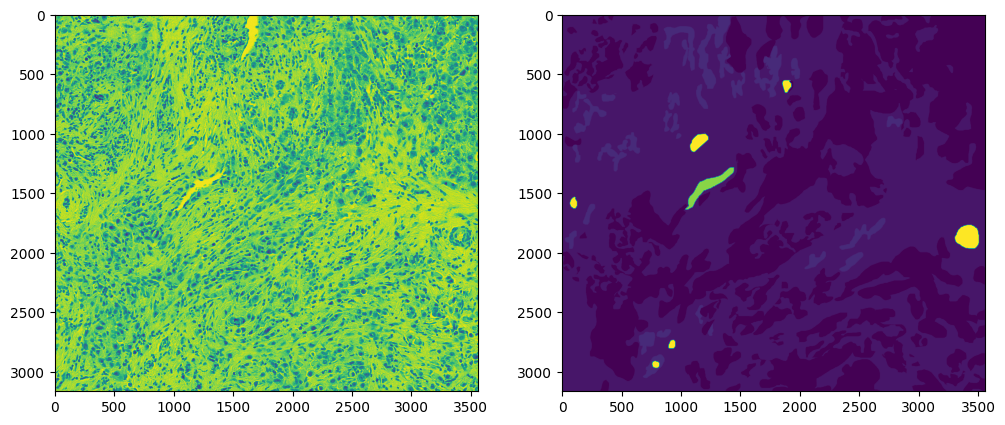

In [5]:
raw_dir + '/images/' 
im = torchvision.io.read_image(raw_dir + '/images/' + name_dict['train'][0]) / 255.0
ma = torchvision.io.read_image(raw_dir + '/masks/' + name_dict['train'][0])

fig, ax = plt.subplots(1, 2, figsize=(12,8))
ax[0].imshow(im[0])
ax[1].imshow(ma[0])

In [6]:
im = nn.moveaxis(im, 0, -1)
idxs_height, idxs_width = get_slice_idxs(im.shape, (512, 512))
slices = slice_image(im, (512, 512, 3), idxs_height, idxs_width)

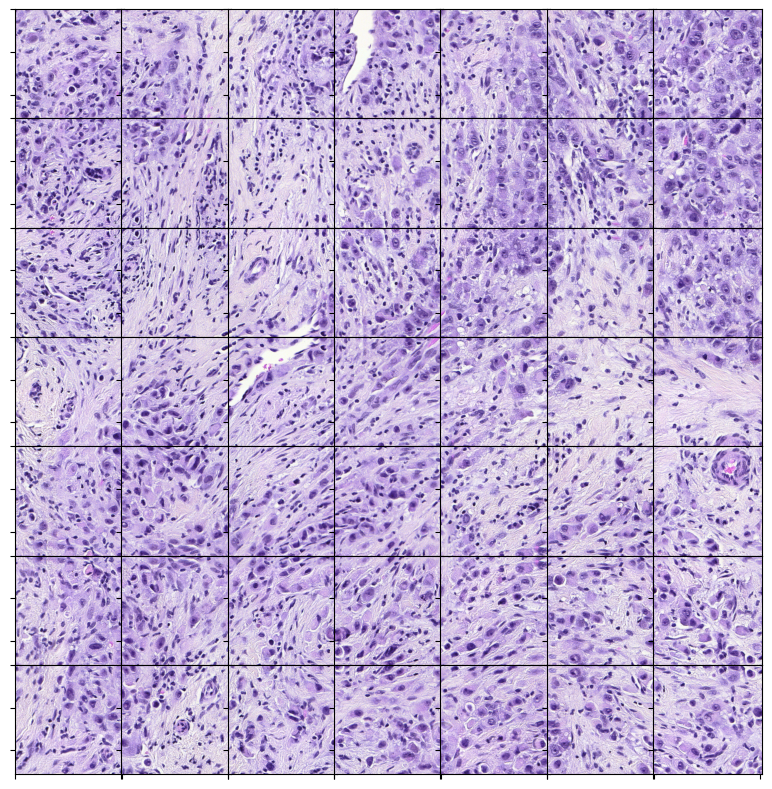

In [7]:
fig, ax = plt.subplots(7,7,figsize=(12,8))

for i in range(7):
    for j in range(7):
        ax[i,j].imshow(slices[i,j])
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
        ax[i,j].set_aspect('equal')

plt.tight_layout()
plt.subplots_adjust(wspace=-.8, hspace=0)

In [8]:
def save_slices(key, idx, image_slices, mask_slices):

    for i in range(image_slices.shape[0]):
        for j in range(image_slices.shape[1]):
            name = f'{key}{idx}_{i}_{j}'
            nn.save((nn.tensor(image_slices[i,j]), nn.tensor(mask_slices[i,j])), f'../data/processed/{key}/{name}')

In [12]:
def process_and_save_data(key, raw_dir, one_hot=True):

    folder = f'../data/processed/{key}'
    if not os.path.exists(folder):
        os.makedirs(folder)

    num_classes = 20

    for idx, name in enumerate(name_dict[key]):
        image = nn.moveaxis(torchvision.io.read_image(raw_dir+'/images/'+name) / 255.0, 0, -1)
        mask = torchvision.io.read_image(raw_dir+'/masks/'+name)

        if one_hot:
            mask = nn.nn.functional.one_hot(mask.to(nn.int64), num_classes=num_classes)[0]

        idxs_height, idxs_width = get_slice_idxs(image.shape, (512, 512))
        
        image_slices = slice_image(image, (512, 512, 3), idxs_height, idxs_width)
        mask_slices = slice_image(mask, (512, 512, num_classes), idxs_height, idxs_width)

        save_slices(key, idx, image_slices, mask_slices)

In [13]:
raw_dir = '../data/raw'
name_dict = split_data(raw_dir)

#for key in ['train', 'validation', 'test']:
process_and_save_data('validation', raw_dir)

RuntimeError: [enforce fail at inline_container.cc:325] . unexpected pos 384 vs 311

In [14]:
mask_dir = sorted([image for image in listdir(raw_dir+'/masks/') if image.endswith('.png')])

for name in mask_dir:
    print(nn.unique(torchvision.io.read_image(raw_dir+'/masks/'+name)))

tensor([1, 2, 3, 4, 9], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  5, 13, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4, 13, 18], dtype=torch.uint8)
tensor([1, 2, 3, 7], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  7, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  6,  7, 10, 13, 18], dtype=torch.uint8)
tensor([1, 2, 4, 7], dtype=torch.uint8)
tensor([ 1,  2,  3, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  6,  7,  9, 18], dtype=torch.uint8)
tensor([1, 2, 3, 4, 7], dtype=torch.uint8)
tensor([ 1,  2,  3,  4, 13, 18], dtype=torch.uint8)
tensor([ 0,  1,  2,  3, 13, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  7, 15], dtype=torch.uint8)
tensor([ 1,  2,  3,  5, 13, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  7, 18, 19], dtype=torch.uint8)
tensor([ 1,  2,  3,  7, 15], dtype=torch.uint8)
tensor([ 1,  2,  6, 18], dtype=torch.uint8)
tensor([ 1,  2,  3,  4, 10], dtype=torch.uint8)
tensor([ 1,  2,  3,  4,  5,  6,  9, 15, 18], dtype=torch.uint8